In [2]:
import sys
sys.path.append('../')

from src.data_manager import DataManager
from src.embeddings_matcher import EmbeddingsMatcher
from src.utils import print_recommendations
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Charger les données
dm = DataManager()
dm.load_profiles()
dm.load_scraped_jobs()

print(f"✓ {len(dm.profiles)} profils")
print(f"✓ {len(dm.jobs)} offres")

✓ 2 profils chargés
✓ 30 offres scrappées chargées
✓ 2 profils
✓ 30 offres


In [4]:
# Entraîner le modèle
# Créer et entraîner le matcher avec embeddings
matcher_embeddings = EmbeddingsMatcher(model_type="word2vec")
matcher_embeddings.train_model(dm.profiles, dm.jobs)

📚 Entraînement du modèle WORD2VEC...
   Documents traités: 32
   Modèle entraîné! Vocabulaire: 1384 mots


In [5]:
# Tester les recommandations
# Tester pour chaque profil
all_recommendations = {}
for profile in dm.profiles:
    recommendations = matcher_embeddings.recommend(profile, dm.jobs)
    all_recommendations[profile['id']] = recommendations
    print_recommendations(profile['name'], recommendations)


Recommandations pour Jean Dupont

1. Data Scientist - Mid level - Nalley Consulting
   Location: Washington, DC
   Salary: None - None
   Score de match: 99.98%
   URL: https://www.indeed.com/viewjob?jk=907a13bcf9a9148a&utm_campaign=google_jobs_apply&utm_source=google_jobs_apply&utm_medium=organic

2. Data Scientist SME - Leidos
   Location: Alexandria, VA
   Salary: None - None
   Score de match: 99.97%
   URL: https://careers.leidos.com/jobs/16894311-data-scientist-sme?utm_campaign=google_jobs_apply&utm_source=google_jobs_apply&utm_medium=organic

3. Data Scientist Jobs - IO Associates
   Location: Washington, VA
   Salary: None - None
   Score de match: 99.97%
   URL: https://www.clearancejobs.com/jobs/8337730/data-scientist?utm_campaign=google_jobs_apply&utm_source=google_jobs_apply&utm_medium=organic

4. Data Scientist   Identity Focus - PlanIT Group, LLC
   Location: Falls Church, VA
   Salary: None - None
   Score de match: 99.97%
   URL: https://www.linkedin.com/jobs/view/data

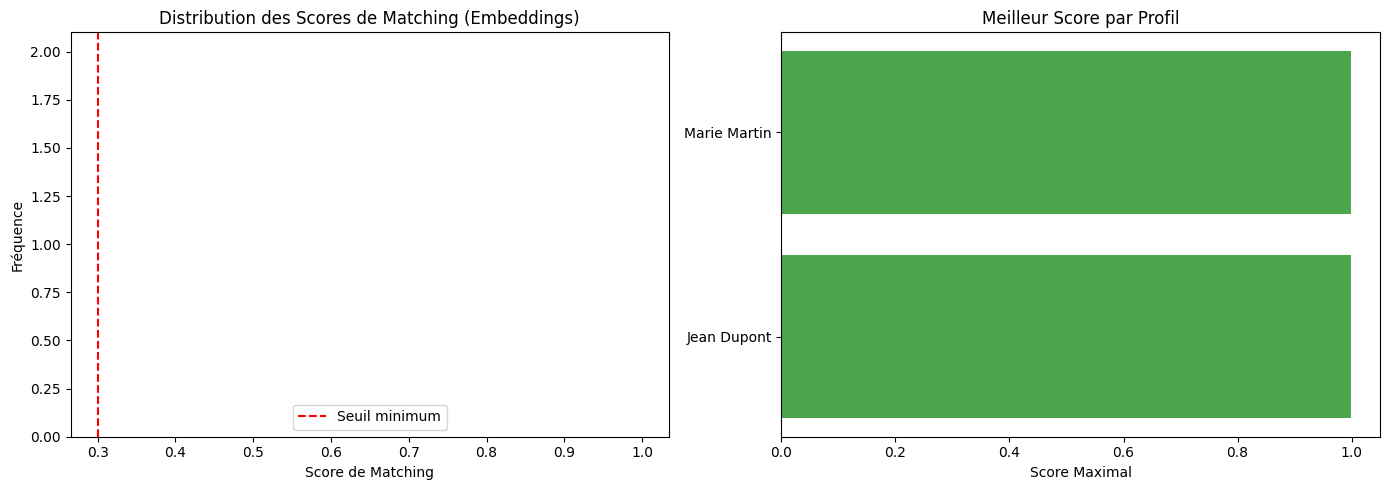

In [6]:
# Analyser les scores
# Extraire tous les scores
all_scores = []
for profile in dm.profiles:
    recommendations = all_recommendations[profile['id']]
    for rec in recommendations:
        all_scores.append({
            'profile': profile['name'],
            'job_title': rec['job_title'],
            'score': rec['score']
        })

df_scores = pd.DataFrame(all_scores)

# Visualiser
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogramme des scores
ax1 = axes[0]
ax1.hist([rec['score'] for recs in all_recommendations.values() for rec in recs], bins=15, color='steelblue')
ax1.set_xlabel('Score de Matching')
ax1.set_ylabel('Fréquence')
ax1.set_title('Distribution des Scores de Matching (Embeddings)')
ax1.axvline(x=0.3, color='red', linestyle='--', label='Seuil minimum')
ax1.legend()

# Scores par profil
ax2 = axes[1]
for profile_id, recs in all_recommendations.items():
    profile_name = next(p['name'] for p in dm.profiles if p['id'] == profile_id)
    scores = [rec['score'] for rec in recs]
    ax2.barh(f"{profile_name}", max(scores) if scores else 0, color='green', alpha=0.7)

ax2.set_xlabel('Score Maximal')
ax2.set_title('Meilleur Score par Profil')

plt.tight_layout()
plt.show()

In [7]:
# Comparer avec TF-IDF (optionnel)
from src.matcher import SimpleMatcher

matcher_tfidf = SimpleMatcher()

print("COMPARAISON TF-IDF vs EMBEDDINGS")
print("="*70)

profile = dm.profiles[0]
recs_tfidf = matcher_tfidf.recommend(profile, dm.jobs)
recs_embeddings = matcher_embeddings.recommend(profile, dm.jobs)

print(f"\n👤 {profile['name']}")
print(f"\nTF-IDF (Top 3):")
for rec in recs_tfidf[:3]:
    print(f"  - {rec['job_title']}: {rec['score']:.1%}")

print(f"\nEmbeddings (Top 3):")
for rec in recs_embeddings[:3]:
    print(f"  - {rec['job_title']}: {rec['score']:.1%}")

COMPARAISON TF-IDF vs EMBEDDINGS

👤 Jean Dupont

TF-IDF (Top 3):

Embeddings (Top 3):
  - Data Scientist - Mid level: 100.0%
  - Data Scientist SME: 100.0%
  - Data Scientist Jobs: 100.0%


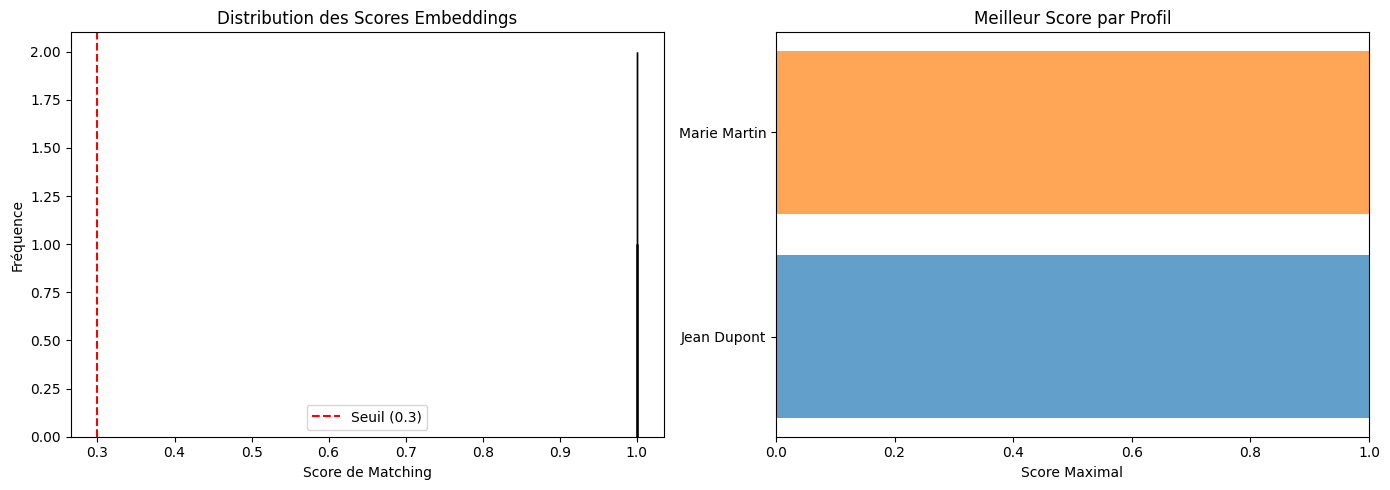


📊 Statistiques des scores:
Score moyen: 99.98%
Score min: 99.97%
Score max: 99.98%


In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Collecter tous les scores
all_results = []
for profile in dm.profiles:
    recommendations = matcher_embeddings.recommend(profile, dm.jobs)
    for rec in recommendations:
        all_results.append({
            'profile': profile['name'],
            'job_title': rec['job_title'],
            'company': rec['company'],
            'score': rec['score']
        })

df = pd.DataFrame(all_results)

# Visualiser les scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogramme des scores
ax1 = axes[0]
ax1.hist(df['score'], bins=20, color='steelblue', edgecolor='black')
ax1.set_xlabel('Score de Matching')
ax1.set_ylabel('Fréquence')
ax1.set_title('Distribution des Scores Embeddings')
ax1.axvline(x=0.3, color='red', linestyle='--', label='Seuil (0.3)')
ax1.legend()

# Scores par profil
ax2 = axes[1]
for profile_name in df['profile'].unique():
    profile_data = df[df['profile'] == profile_name]
    ax2.barh(profile_name, profile_data['score'].max(), alpha=0.7)

ax2.set_xlabel('Score Maximal')
ax2.set_title('Meilleur Score par Profil')
ax2.set_xlim(0, 1)

plt.tight_layout()
plt.show()

print(f"\n📊 Statistiques des scores:")
print(f"Score moyen: {df['score'].mean():.2%}")
print(f"Score min: {df['score'].min():.2%}")
print(f"Score max: {df['score'].max():.2%}")